In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
#from helpers import read_metrics_csvs, read_fastas
import math
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
import matplotlib as mpl
from IPython import display
from collections import OrderedDict
from pathlib import Path
import urllib.request

In [2]:
def passes_filter(row, esm_1v_cutoff): #not including "starts with M"
    if row["longest_repeat_1"] > -4 and row["longest_repeat_2"] > -3 and row["ESM-1v"] > esm_1v_cutoff and row["phobius_tm_count"] == 0: 
        return True
    else:
        return False
name_to_pf = {"Phage lysozyme": "PF00959",
            "Glycosidase hydrolase": "PF05838",
            "Glucosaminidase": "PF01832",
            "Transglycosylase": "PF06737",
            "Pesticin": "PF16754",
            "Chorismate mutase": "CM"
           }

In [3]:
metrics_path = Path("../data/CM_table.csv")
if not metrics_path.exists():
    urllib.request.urlretrieve("https://zenodo.org/record/7808981/files/CM_table.csv", metrics_path)
CM_df = pd.read_csv(metrics_path)
CM_df["Family_name"] = "Chorismate mutase"

metrics_path = Path("../data/lysozyme_table.csv")
if not metrics_path.exists():
    urllib.request.urlretrieve("https://zenodo.org/record/7808981/files/lysozyme_table.csv", metrics_path)
lysozyme_df = pd.read_csv(metrics_path)

metrics_path = Path("../data/lysozyme_training.csv")
if not metrics_path.exists():
    urllib.request.urlretrieve("https://zenodo.org/record/7808981/files/lysozyme_training.csv", metrics_path)
lysozyme_training_df = pd.read_csv(metrics_path)

outdir="figs"

In [4]:
set_colors_map=OrderedDict([
    (True,"#17becf"),
    (False,"#9467bd"),
])

thresholds=dict()

In [5]:
df = CM_df[CM_df["Model"] == "natural"]
thresholds["CM"] = df.sort_values("ESM-1v", ascending=False).iloc[int(len(df)*0.1)]["ESM-1v"]

for family in lysozyme_training_df["Family"].unique():
    df = lysozyme_training_df[(lysozyme_training_df["Family"] == family)]
    thresholds[family] = df.sort_values("ESM-1v", ascending=False).iloc[int(len(df)*0.1)]["ESM-1v"]
thresholds

{'CM': -0.279203951,
 'PF16754': -0.3616018,
 'PF06737': -0.114838302,
 'PF05838': -0.196797594,
 'PF01832': -0.191023946,
 'PF00959': -0.239952624}

In [6]:
combined_data = pd.concat((CM_df,lysozyme_df), ignore_index=True)[["id","Model", "Family",  "Family_name", "Activity", "longest_repeat_1", "longest_repeat_2", "phobius_tm_count", "ProteinMPNN", "ESM-1v"]]
combined_data = combined_data[(combined_data["Model"] != "natural") & (combined_data["Model"] != "profile")]
combined_data = combined_data.dropna(subset=["Activity"],axis='rows')
combined_data["Passes"] = combined_data.apply(lambda x:passes_filter(x, thresholds[x["Family"]]), axis=1)

/tmp/ipykernel_8043/88988314.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


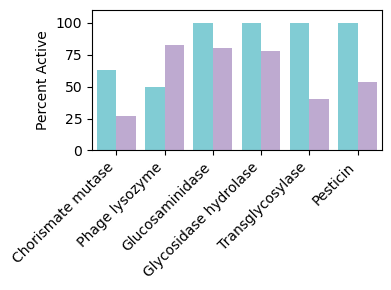

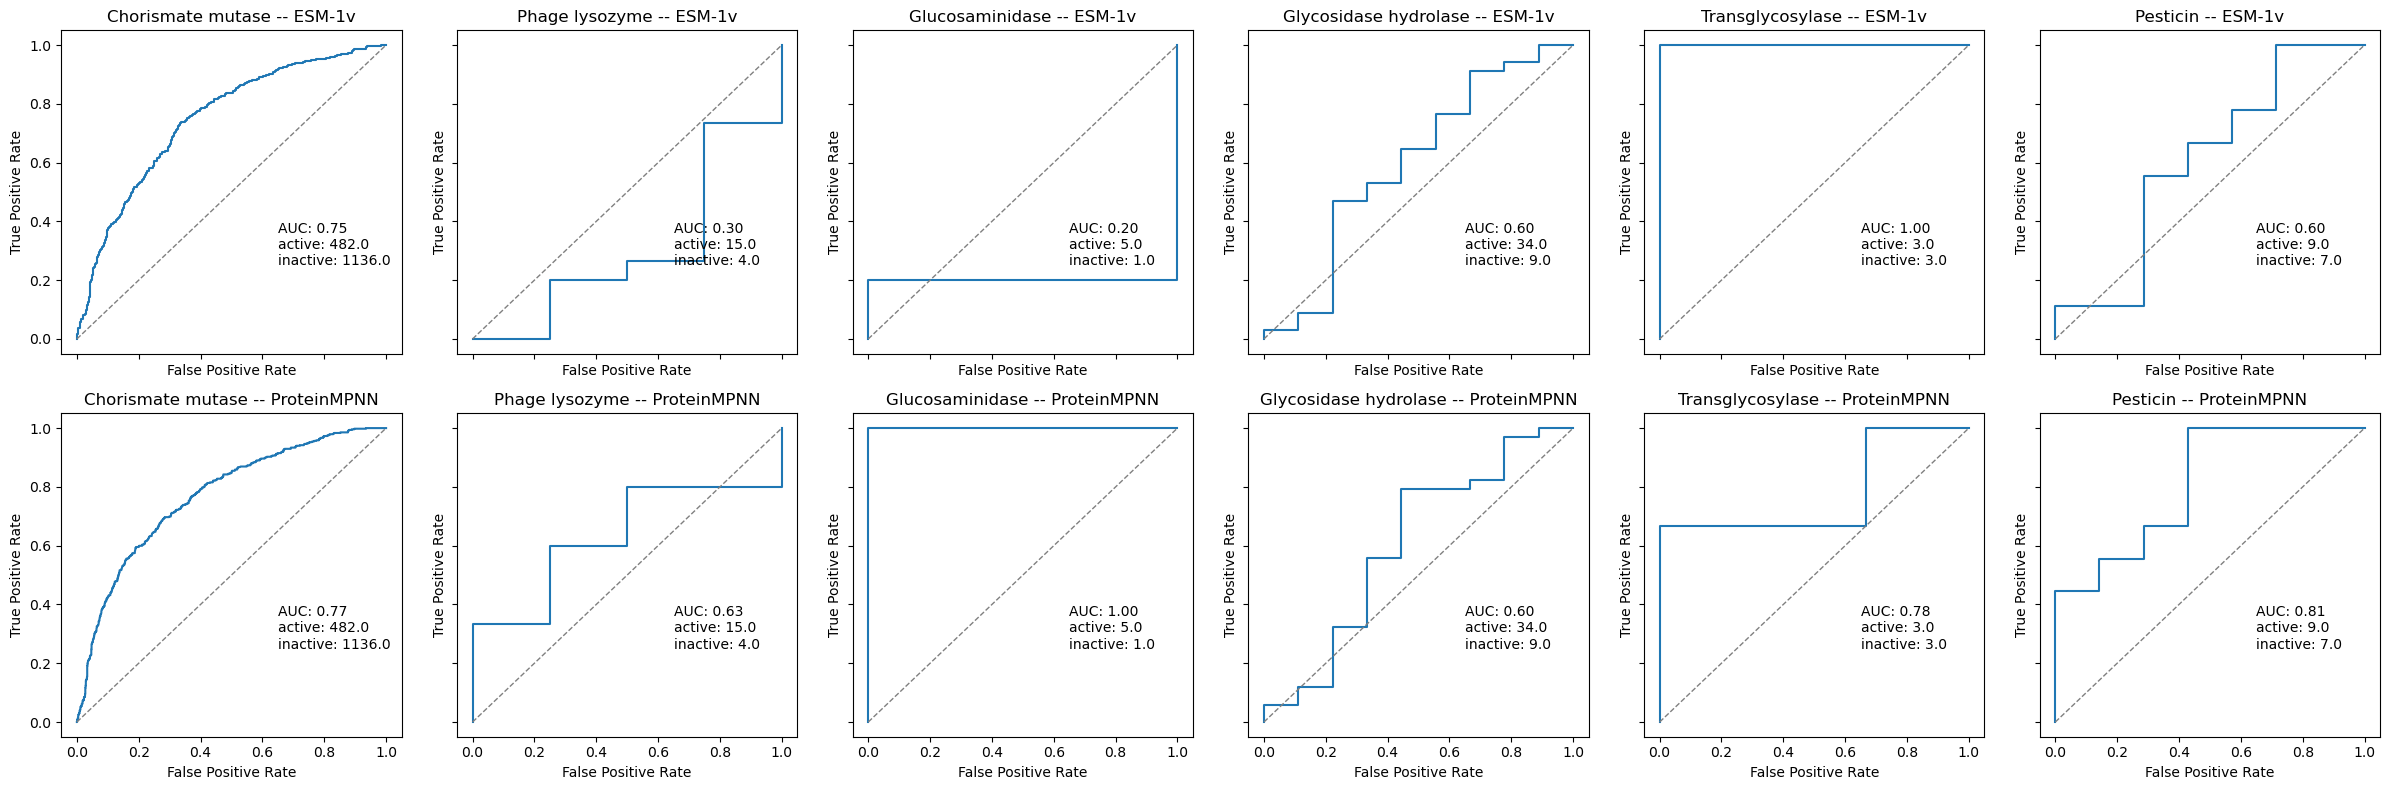

In [7]:
#combined_data.groupby("Family",
families=("Chorismate mutase", "Phage lysozyme", "Glucosaminidase", "Glycosidase hydrolase", "Transglycosylase", "Pesticin")
by_family = {"Family":list(), "Passes":list(), "Percent Active":list(), "Count":list(), "Active":list()}
for family in families:
    for passes_ in (True,False):
        sub_df = combined_data[(combined_data["Passes"] == passes_) & (combined_data["Family_name"] == family)]
        active = sum(sub_df["Activity"])
        total = len(sub_df)
        by_family["Family"].append(family)
        by_family["Passes"].append(passes_)
        by_family["Percent Active"].append(100 * (active / total))
        by_family["Count"].append(total)
        by_family["Active"].append(active)
#pd.DataFrame(by_family)
#print(sum(banded["Count"]))
fig,ax = plt.subplots(1,1, figsize=(4,3), sharex=True, sharey=True)
sns.barplot(data=pd.DataFrame(by_family), x="Family", y="Percent Active",  hue="Passes",  palette=set_colors_map, alpha=0.6, order=families, hue_order=(True,False), ax=ax)
ax.set_ylim(0,110)
ax.get_legend().remove()
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Passes")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), 
                      rotation=45, 
                      horizontalalignment='right')
fig.tight_layout()
fig.savefig(outdir+"/published_validation_bar.png", dpi=300)



fig, axes = plt.subplots(2, 6, sharex=True, sharey='row', figsize=(24,8))
for model_i, family in enumerate(families):
    df = combined_data[(combined_data["Family_name"] == family) 
                ]
    metric_i = 0
    model = family

    #print(df)
    for metric in ["ESM-1v","ProteinMPNN"]:

        fpr, tpr, _ = roc_curve( df["Activity"], df[metric])
        auc_value = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(axes[metric_i, model_i])
        lw=1
        roc_display.ax_.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
        metric_i += 1
        num_active = df["Activity"].sum()
        num_inactive = df["Activity"].size - num_active
        roc_display.ax_.text(.65,.25, f"AUC: {auc_value:0.2f}\nactive: {num_active}\ninactive: {num_inactive}")
        roc_display.ax_.set_title(f"{model} -- {metric}")
        #ax.get_legend().remove()
fig.tight_layout()
fig.show()
fig.savefig(outdir + "/published_validation_AUC.png", dpi=300)


Chorismate mutase
Pass sequence filter: 82 active out of 130 (63%) 
Fail sequence filter: 400 active out of 1488 (27%) 

Phage lysozyme
Pass sequence filter: 1 active out of 2 (50%) 
Fail sequence filter: 14 active out of 17 (82%) 

Glucosaminidase
Pass sequence filter: 1 active out of 1 (100%) 
Fail sequence filter: 4 active out of 5 (80%) 

Glycosidase hydrolase
Pass sequence filter: 2 active out of 2 (100%) 
Fail sequence filter: 32 active out of 41 (78%) 

Transglycosylase
Pass sequence filter: 1 active out of 1 (100%) 
Fail sequence filter: 2 active out of 5 (40%) 

Pesticin
Pass sequence filter: 1 active out of 1 (100%) 
Fail sequence filter: 8 active out of 15 (53%) 


/tmp/ipykernel_8043/3616421440.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


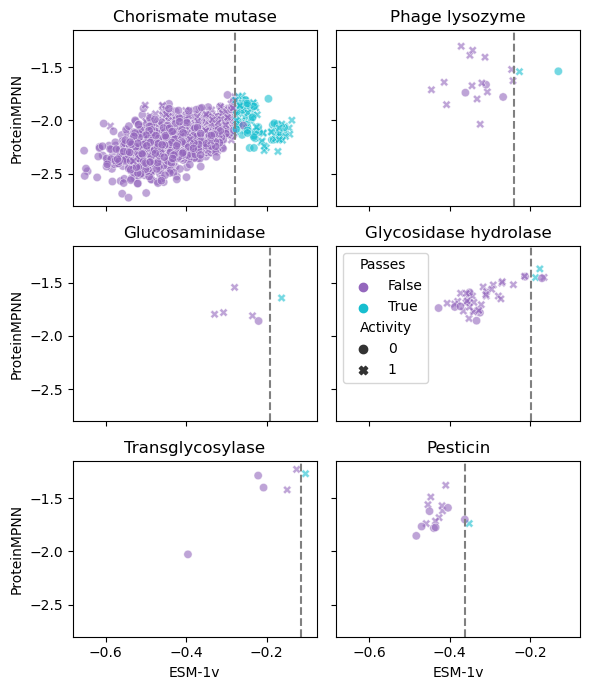

In [8]:
families=("Chorismate mutase", "Phage lysozyme", "Glucosaminidase", "Glycosidase hydrolase", "Transglycosylase", "Pesticin")

fig, axes = plt.subplots(3,2, figsize=(6,7), sharex=True, sharey=True)
axes = axes.flatten()
for i, family in enumerate(families):
    df = combined_data[combined_data["Family_name"] == family].copy()
    sns.scatterplot(x="ESM-1v", y="ProteinMPNN", data=df, alpha=0.6, hue="Passes", ax=axes[i], style="Activity", style_order=[0,1], palette=set_colors_map)

    axes[i].axvline(thresholds[name_to_pf[family]], color="grey", linestyle="--")
    axes[i].set_title(family)
    if i != 3:
        axes[i].get_legend().remove()
    pass_counts = df[df["Passes"] == True].groupby("Activity").count()["Model"]
    print(f"\n{family}\nPass sequence filter: {pass_counts.get(1,0)} active out of {pass_counts.get(1,0) + pass_counts.get(0,0)} ({round(100*pass_counts.get(1,0)/(pass_counts.get(1,0) + pass_counts.get(0,0)))}%) ")

    pass_counts = df[df["Passes"] == False].groupby("Activity").count()["Model"]
    print(f"Fail sequence filter: {pass_counts.get(1,0)} active out of {pass_counts.get(1,0) + pass_counts.get(0,0)} ({round(100*pass_counts.get(1,0)/(pass_counts.get(1,0) + pass_counts.get(0,0)))}%) ")    
    
fig.tight_layout()
fig.show()
fig.savefig(outdir + "/published_validation_scatter.png", dpi=300)
